In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
#Colormap
from matplotlib.colors import ListedColormap

#Create custom color palette for generation technologies
colorsList = ['#DA9A2F','#B1B2B4','#76C26A','#c5abe3','#3B9ED8','#DC5CE5']
techmap = ListedColormap(colorsList)
pv_col = techmap(0)
wind_col = techmap(1)
bm_col = techmap(2)
gt_col = techmap(3)
hydro_col = techmap(4)
imp_col = techmap(5)
stomap = ListedColormap([pv_col, bm_col, imp_col])


In [3]:
techs = ['PV','wind','biomass','geothermal','hydro']
techsBL = ['PV', 'wind', 'biomass', 'geothermal', 'hydro', 'imports']

In [4]:
#Biomass capacities
bmPlants = pd.read_csv("bmPlants_Grefrath.csv",sep=";",decimal=",")
bmPlants['plantCapacity_kw_el'] = pd.to_numeric(bmPlants['plantCapacity_kw_el'].str.replace(',','.'), errors='coerce')
wte = bmPlants.iloc[6].loc['plantCapacity_kw_el']
wc = bmPlants.iloc[7].loc['plantCapacity_kw_el']
chp2 = bmPlants.iloc[8].loc['plantCapacity_kw_el']
chp3 = bmPlants.iloc[9].loc['plantCapacity_kw_el']
chp4 = bmPlants.iloc[10].loc['plantCapacity_kw_el']

# Importing scenario data

In [5]:
folder = 'Baseline/'

co2 = pd.read_csv(folder + 'TotalCO2Emissions.csv')
cost = pd.read_csv(folder + 'TotalCost.csv')

elSurplus = pd.read_csv(folder + 'ElectricitySurplus.csv')
imports = pd.read_csv(folder + 'ImportFlows.csv')
storage = pd.read_csv(folder + 'StorageFlows.csv')
production = pd.read_csv(folder + 'YearlyProductionTS.csv')

units = pd.read_csv(folder + 'InstalledUnits.csv')

#VollCostShare = pd.read_csv(folder + 'VollCostShare.csv')
#VollAvCost = pd.read_csv(folder + 'VollAverageCost.csv')
#VollTotCost = pd.read_csv(folder + 'VollTotalCost.csv')
#LostLoad = pd.read_csv(folder + 'VollLostLoad.csv')

In [6]:
elSurplus[['season','day','hour']]=elSurplus['TS'].str.rsplit('_',3,expand=True) #separate into columns for grouping analysis
elSurplus['TS'] = elSurplus['MY'].astype(str) + "_" + elSurplus['TS'] #combine for y-axis ticks
elSurplus['hour'] = elSurplus['hour'].astype('int64')
#elSurplus.drop('Val',axis=1, inplace=True)
ts = (elSurplus['season']+"_"+elSurplus['day']+"_"+elSurplus['hour'].astype(str)).iloc[:108]

In [7]:
totImport = pd.read_csv(folder + 'Import.csv',index_col="MY").rename(columns={'Val':'Import'})

# Data Preparation

### Converting number of units to installed capacities and aggregating generators by type of energy source

In [8]:
units.loc[units['TC_ds'].str.contains('PV'),'Val'] = units['Val']*0.26 # A PV unit has a capacity of 0.26 kW
units.loc[units['TC_ds'].str.contains('WasteToEnergy'),'Val'] =  units['Val']*wte
units.loc[units['TC_ds'].str.contains('WoodyCombustion'),'Val'] =  units['Val']*wc
units.loc[units['TC_ds'].str.contains('Chp_2'),'Val'] =  units['Val']*chp2
units.loc[units['TC_ds'].str.contains('Chp_3'),'Val'] =  units['Val']*chp3
units.loc[units['TC_ds'].str.contains('Chp_4'),'Val'] =  units['Val']*chp4

In [9]:
pvCap = units[units['TC_ds'].str.contains("PV")].groupby(by='MY').Val.sum()
windCap = units[units['TC_ds'].str.contains("wind")].groupby(by='MY').Val.sum()*1600 #multiply to get installed capacity as kW (typically 1600 or 1620kW)
bmCap = units[units['TC_ds'].str.contains("biomass")].groupby(by='MY').Val.sum()
gtCap = units[units['TC_ds'].str.contains("geothermal")].groupby(by='MY').Val.sum() 
hydroCap = units[units['TC_ds'].str.contains("hydro")].groupby(by='MY').Val.sum()
totCap = pd.DataFrame({'PV':pvCap, 'wind':windCap, 'biomass':bmCap,'geothermal':gtCap,'hydro':hydroCap}).fillna(0)
totalCap = units.groupby(by=['MY']).Val.sum()

### Timeseries

In [10]:
storage['TS'] = storage['MY'].astype(str) + "_" + storage['TS']
elStorage = pd.merge(elSurplus[['TS','MY','season','day','hour']],storage[['TS','Val']],on='TS',how='left').fillna(0).set_index('TS')

In [11]:
imports['TS'] = imports['MY'].astype(str) + "_" + imports['TS'] #combine for y-axis ticks - careful since overwriting!
elImports = pd.merge(elSurplus[['TS','MY','season','day','hour']],imports[imports['EC']=="el"][['TS','Val']],on="TS",how='left').fillna(0)

In [12]:
LL = pd.DataFrame()
#LostLoad['TS'] = LostLoad['MY'].astype(str) + "_" + LostLoad['TS'] #combine for y-axis ticks - careful since overwriting!
#LL = pd.merge(elSurplus[['TS','MY','season','day','hour']],LostLoad[['TS','Val']],on="TS",how='left').fillna(0)

In [13]:
production['TS'] = production['MY'].astype(str) + "_" + production['TS'] #combine for y-axis ticks - careful since overwriting!
elGeneration = pd.merge(elSurplus[['TS','MY','season','day','hour']],production[production['EC']=="el"][['TS','Val']],on="TS",how='left').fillna(0)

In [14]:
pvGen = production[(production['EC']=="el")&(production['TC_ds'].str.contains("PV"))].groupby(by=['TS']).Val.sum()
gtGen = production[(production['EC']=="el")&(production['TC_ds'].str.contains("geothermal"))].groupby(by=['TS']).Val.sum()
windGen = production[(production['EC']=="el")&(production['TC_ds'].str.contains("wind"))].groupby(by=['TS']).Val.sum()
bmGen = production[(production['EC']=="el")&(production['TC_ds'].str.contains("biomass"))].groupby(by=['TS']).Val.sum()
hydroGen = production[(production['EC']=="el")&(production['TC_ds'].str.contains("hydro"))].groupby(by=['TS']).Val.sum()
totalGen = production[production['EC']=="el"].groupby(by=['TS']).Val.sum()
totGenTS = pd.DataFrame({'PV':pvGen, 'wind':windGen, 'biomass':bmGen,'geothermal':gtGen,'hydro':hydroGen,'Total':totalGen}).fillna(0)
totGenTS = totGenTS.reindex(elSurplus.TS).fillna(0)
totGenTS = totGenTS.merge(elSurplus.astype('object')[['MY','TS','season','day','hour']],left_index=True,right_on='TS').set_index('TS')

<AxesSubplot:xlabel='MY'>

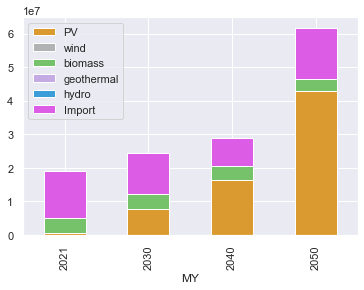

In [15]:
totGen = totGenTS.groupby(by='MY').sum().merge(totImport[totImport['EC']=='el'],left_index=True, right_index=True).drop(['Total'],axis=1)
totGen.plot(kind='bar', stacked=True,cmap=techmap)

# Sensitivity analysis

In [16]:
#Sensitivity analysis where the VoLL rate was changed, applied to the total autarky scenario

sensitivity = pd.read_csv('sensitivity.csv',index_col='Unnamed: 0').rename(index={'Baseline':'100'})
ref = 2.723547e+08 #Cost of Baseline scenario (cost['TotalCost'])
sensitivity.head()

,total cost (Eur),total voll (Eur),avg voll (Eur/kWh),load (kWh),lost load (kWh)
100,4.435171e+08,3.770709e+07,14.455852,1.144393e+08,446993.257906
90,4.334692e+08,3.502205e+07,12.882871,1.163636e+08,474678.653368
80,4.363074e+08,3.227451e+07,11.519229,1.146397e+08,489659.515521
70,4.186790e+08,3.147189e+07,10.428445,1.016774e+08,546610.035635
60,4.271785e+08,3.072942e+07,9.374261,1.148289e+08,651166.771795


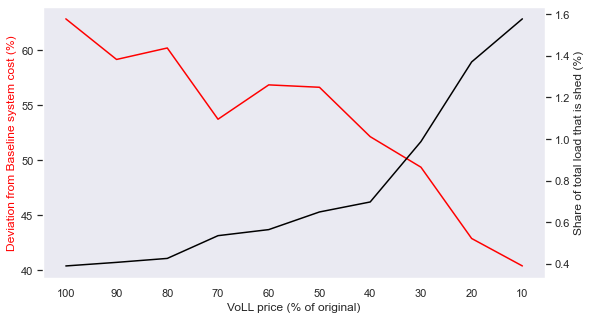

In [17]:
#Chepaer VoLL means that it is used omre but the share of the total costs due to it reduces as it is cheaper to use 
# + At most, 0.3% of the load is not served

fig, ax = plt.subplots(figsize=(9,5))
#plt.title('Cost reductions and increases in Lost Load due to reduction of VoLL price')
ax.plot((100*sensitivity[['total cost (Eur)']]/ref - 100),color='red')
ax.set_ylabel("Deviation from Baseline system cost (%)",color="red")
ax.set_xlabel('VoLL price (% of original)')
ax2=ax.twinx()
ax2.plot((100*sensitivity['lost load (kWh)']/(sensitivity['load (kWh)']+sensitivity['lost load (kWh)'])),color='black')
ax2.set_ylabel("Share of total load that is shed (%)")
ax.grid(False)
ax2.grid(False)

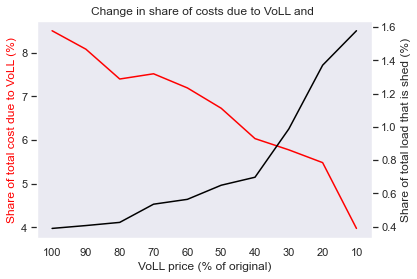

In [18]:
#Chepaer VoLL means that it is used omre but the share of the total costs due to it reduces as it is cheaper to use 
# + At most, 0.3% of the load is not served

fig, ax = plt.subplots()
plt.title('Change in share of costs due to VoLL and ')
ax.plot((100*sensitivity['total voll (Eur)']/sensitivity['total cost (Eur)']),color='red')
ax.set_ylabel("Share of total cost due to VoLL (%)",color="red")
ax.set_xlabel('VoLL price (% of original)')
ax2=ax.twinx()
ax2.plot((100*sensitivity['lost load (kWh)']/(sensitivity['load (kWh)']+sensitivity['lost load (kWh)'])),color='black')
ax2.set_ylabel("Share of total load that is shed (%)")
ax.grid(False)
ax2.grid(False)

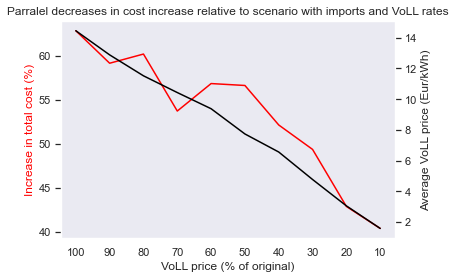

In [19]:
#Showing that reduction of Voll-rate decreases the cost increase relative to the baseline scenario from 66% to 40%

fig, ax = plt.subplots()
plt.title('Parralel decreases in cost increase relative to scenario with imports and VoLL rates')
ax.plot((100*sensitivity[['total cost (Eur)']]/ref)-100,color='red')
ax.set_ylabel('Increase in total cost (%)',color='red')
ax.set_xlabel('VoLL price (% of original)')
#ax.set_title('Sysetm-level cost of autarky scenarios with varying VoLL price relative to scenario with imports')
ax2=ax.twinx()
ax2.plot(sensitivity['avg voll (Eur/kWh)'],color='black')
ax2.set_ylabel('Average VoLL price (Eur/kWh)')
ax2.set_xlabel('VoLL price (% of original)')
#ax2.set_title('Average price paid to shed load')
ax.grid(False)
ax2.grid(False)

# Overview tables

In [20]:
overview = pd.read_csv('overview.csv').set_index('Scenario')
overview #Total Cost (Eur/person/year), TotalCo2 (kgCO2/person/year), LostLoadShare (LostLoad/(TotalLoad)), LostLoad (kWh/person/year), AvgVoll (Eur/kWh), Voll (Eur/person/year), VolLshare (Total VolL COst / Total System Cost), ratio (Total Cost(Baseline) / total cost (scenario), CO2 costs (mitigation costs vs Baseline scenario in Eur / t CO2))

,TotalCost,TotalCO2,Storage,LostLoadShare,Lost Load,AvgVoll,Voll,VollShare,Ratio,CO2Costs
Scenario,,,,,,,,,,
Baseline,473.358164,397.387727,111118.0,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,NaN
ElAut,642.217343,318.677673,81604.7,0.000000,0.000000,0.000000,0.000000,0.000000,135.672603,2145.331761
ElAutVoll,596.407283,376.115221,179883.0,0.657367,8.950445,10.582808,43.228363,7.248128,125.994929,5784.420500
Aut,909.026016,0.000000,107363.0,0.000000,0.000000,0.000000,0.000000,0.000000,192.037676,1096.329409
AutVoll,770.842154,0.000000,82490.6,0.389074,7.574616,14.455852,65.535724,8.501834,162.845433,748.598836


In [21]:
overview[['TotalCost','Ratio','TotalCO2','LostLoadShare','VollShare','Storage']]

,TotalCost,Ratio,TotalCO2,LostLoadShare,VollShare,Storage
Scenario,,,,,,
Baseline,473.358164,100.000000,397.387727,0.000000,0.000000,111118.0
ElAut,642.217343,135.672603,318.677673,0.000000,0.000000,81604.7
ElAutVoll,596.407283,125.994929,376.115221,0.657367,7.248128,179883.0
Aut,909.026016,192.037676,0.000000,0.000000,0.000000,107363.0
AutVoll,770.842154,162.845433,0.000000,0.389074,8.501834,82490.6


# Visualizing results

# Lost Load Boxplots

In [22]:
LL = pd.read_csv('ElAutVoll/VollLostLoadFlows.csv')
LL['TS'] = LL['MY'].astype(str) + "_" + LL['TS']
LostLoad = elSurplus.drop(columns='Val')
LostLoadEl = pd.merge(LostLoad, LL[['TS','Val']], on='TS',how='left').fillna(0)

LL = pd.read_csv('AutVoll/VollLostLoadFlows.csv')
LL['TS'] = LL['MY'].astype(str) + "_" + LL['TS']
LostLoad = pd.merge(LostLoad, LL[['TS','Val']], on='TS',how='left').fillna(0)

In [23]:
LostLoad

,MY,TS,season,day,hour,Val
0,2021,2021_sp_wd_1,sp,wd,1,0.0
1,2021,2021_sp_wd_6,sp,wd,6,0.0
2,2021,2021_sp_wd_8,sp,wd,8,0.0
3,2021,2021_sp_wd_10,sp,wd,10,0.0
4,2021,2021_sp_wd_12,sp,wd,12,0.0
...,...,...,...,...,...,...
427,2050,2050_wi_ex_12,wi,ex,12,0.0
428,2050,2050_wi_ex_14,wi,ex,14,0.0
429,2050,2050_wi_ex_16,wi,ex,16,0.0
430,2050,2050_wi_ex_18,wi,ex,18,0.0


<AxesSubplot:xlabel='MY', ylabel='Val'>

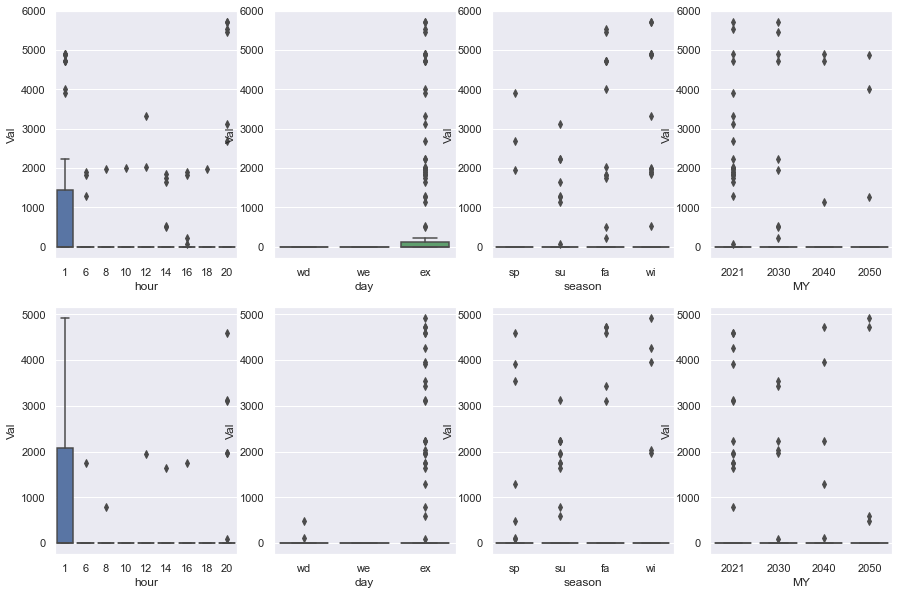

In [24]:
#Timing of Lost Load
fig, ax=plt.subplots(2,4,figsize=(15,10))
sns.boxplot(x='hour',y='Val',data=LostLoad,ax=ax[0,0])
sns.boxplot(x='day',y='Val',data=LostLoad,ax=ax[0,1])
sns.boxplot(x='season',y='Val',data=LostLoad,ax=ax[0,2])
sns.boxplot(x='MY',y='Val',data=LostLoad,ax=ax[0,3])

sns.boxplot(x='hour',y='Val',data=LostLoadEl,ax=ax[1,0])
sns.boxplot(x='day',y='Val',data=LostLoadEl,ax=ax[1,1])
sns.boxplot(x='season',y='Val',data=LostLoadEl,ax=ax[1,2])
sns.boxplot(x='MY',y='Val',data=LostLoadEl,ax=ax[1,3])

#ax[0].set_title("Lost Load by hour")
#ax[1].set_title("Lost Load by day type")
#ax[2].set_title("Lost Load by season")

#LostLoad.groupby('hour')['Val'].describe()

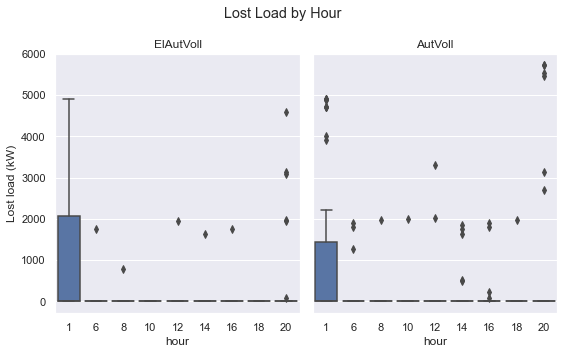

In [25]:
fig, ax=plt.subplots(1,2,figsize=(8,5),sharey=True)
sns.boxplot(x='hour',y='Val',data=LostLoadEl,ax=ax[0])
sns.boxplot(x='hour',y='Val',data=LostLoad,ax=ax[1])

plt.suptitle('Lost Load by Hour')
ax[0].set_title('ElAutVoll')
ax[1].set_title('AutVoll')

for ax in ax.flat:
    ax.set_ylabel('Lost load (kW)')
    ax.label_outer()

plt.tight_layout()
fig.savefig('plots/HourlyBoxplot.png')

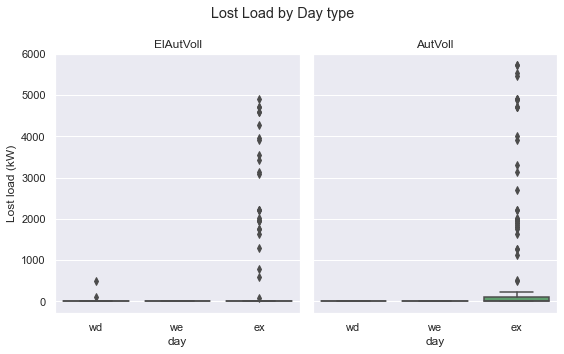

In [26]:
fig, ax=plt.subplots(1,2,figsize=(8,5),sharey=True)
sns.boxplot(x='day',y='Val',data=LostLoadEl,ax=ax[0])
sns.boxplot(x='day',y='Val',data=LostLoad,ax=ax[1])

plt.suptitle('Lost Load by Day type')
ax[0].set_title('ElAutVoll')
ax[1].set_title('AutVoll')

for ax in ax.flat:
    ax.set_ylabel('Lost load (kW)')
    ax.label_outer()

plt.tight_layout()
fig.savefig('plots/DailyBoxplot.png')

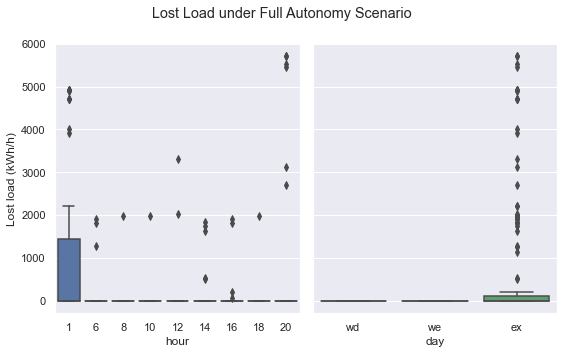

In [27]:
fig, ax=plt.subplots(1,2,figsize=(8,5))
sns.boxplot(x='hour',y='Val',data=LostLoad,ax=ax[0])
sns.boxplot(x='day',y='Val',data=LostLoad,ax=ax[1])

plt.suptitle('Lost Load under Full Autonomy Scenario')

for ax in ax.flat:
    ax.set_ylabel('Lost load (kWh/h)')
    ax.label_outer()

plt.tight_layout()

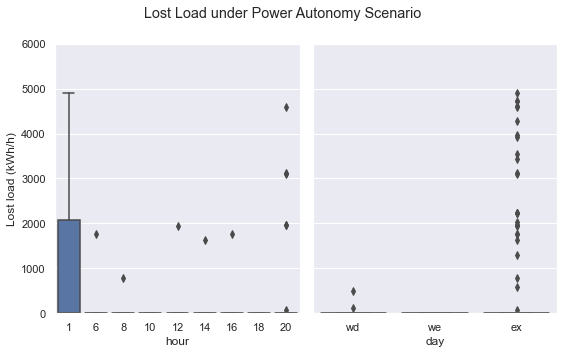

In [28]:
fig, ax=plt.subplots(1,2,figsize=(8,5))
sns.boxplot(x='hour',y='Val',data=LostLoadEl,ax=ax[0])
sns.boxplot(x='day',y='Val',data=LostLoadEl,ax=ax[1])

plt.suptitle('Lost Load under Power Autonomy Scenario')

for ax in ax.flat:
    ax.set_ylabel('Lost load (kWh/h)')
    ax.label_outer()
    ax.set_ylim(0,6000)

plt.tight_layout()

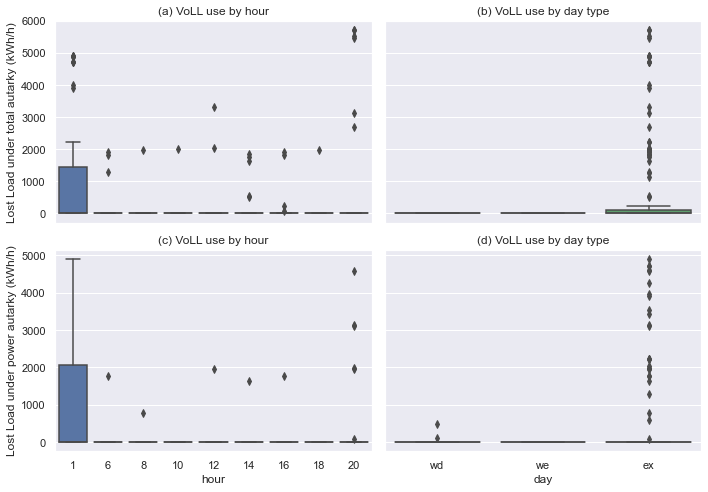

In [29]:
fig, ax=plt.subplots(2,2,figsize=(10,7))
sns.boxplot(x='hour',y='Val',data=LostLoad,ax=ax[0,0])
sns.boxplot(x='day',y='Val',data=LostLoad,ax=ax[0,1])

sns.boxplot(x='hour',y='Val',data=LostLoadEl,ax=ax[1,0])
sns.boxplot(x='day',y='Val',data=LostLoadEl,ax=ax[1,1])

ax[0,0].set_title('(a) VoLL use by hour')
ax[0,1].set_title('(b) VoLL use by day type')
ax[1,0].set_title('(c) VoLL use by hour')
ax[1,1].set_title('(d) VoLL use by day type')

ax[0,0].set_ylabel('Lost Load under total autarky (kWh/h)')
ax[1,0].set_ylabel('Lost Load under power autarky (kWh/h)')

for ax in ax.flat:
    #ax.set_xlabel(None)
    #ax.set_ylabel('Lost load (kWh)')
    ax.label_outer()

plt.tight_layout()

## System composition

In [30]:
#Baseline
imports[imports['EC']=='gs'].groupby(by='MY').sum()

,Val
MY,
2021,507897.782838
2030,414417.137335
2040,461324.873218
2050,140535.102197


In [31]:
#El-aut
imports[imports['EC']=='gs'].groupby(by='MY').sum()

,Val
MY,
2021,507897.782838
2030,414417.137335
2040,461324.873218
2050,140535.102197


In [32]:
#El-aut-voll
imports[imports['EC']=='gs'].groupby(by='MY').sum()

,Val
MY,
2021,507897.782838
2030,414417.137335
2040,461324.873218
2050,140535.102197


Text(0, 0.5, '%')

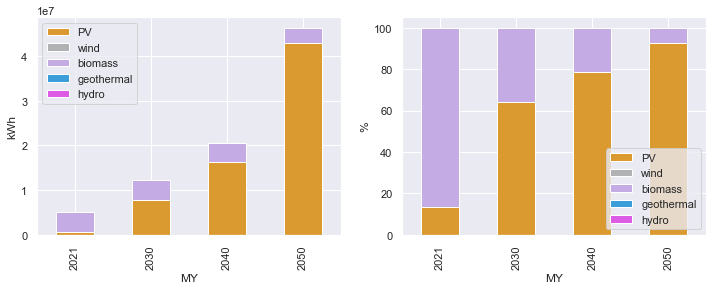

In [33]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
#Total generation by year
totGenTS.groupby(by='MY').sum()[techs].plot(ax=ax[0],kind='bar',stacked=True,cmap=techmap)
ax[0].set_ylabel('kWh')
#Generation mix by year
(100*totGenTS.groupby(by='MY')[techs].sum().T/totGenTS.groupby(by='MY')[techs].sum().T.sum()).T.plot(ax=ax[1],kind='bar',stacked=True,cmap=techmap)
ax[1].set_ylabel('%')

<AxesSubplot:xlabel='MY,day,hour'>

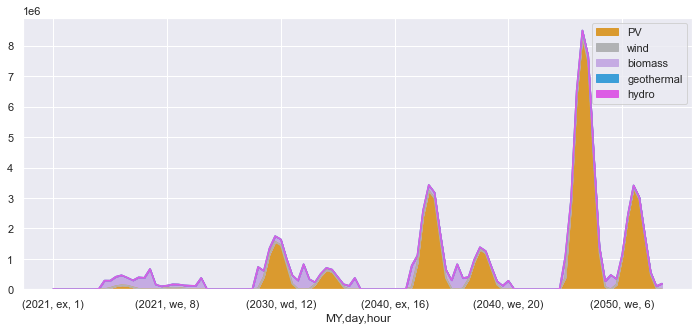

In [34]:
totGenTS.groupby(by=['MY','day','hour']).sum()[techs].plot(kind='area',stacked=True,cmap=techmap,figsize=(12,5))
#fig, ax=plt.subplots(figsize=(18,10))
#totGenTS[techs].loc['2021_sp_wd_1':'2021_wi_ex_20'].plot(kind='bar',stacked=True,cmap=techmap,ax=ax)

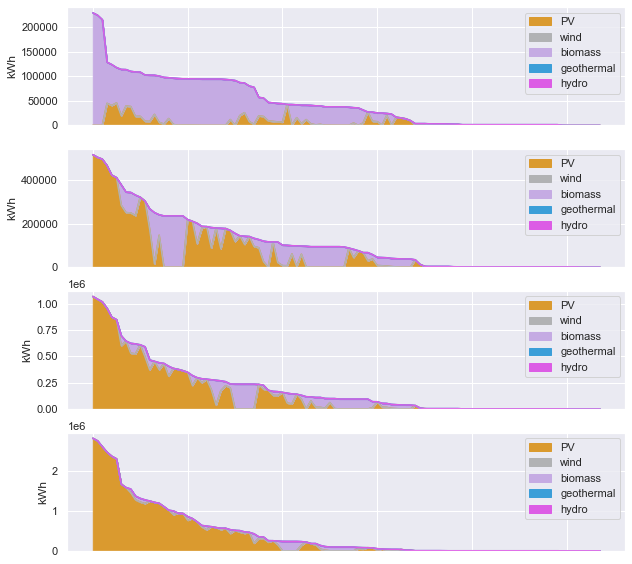

In [35]:
fig, ax=plt.subplots(4,1,figsize=(10,10))
totGenTS[totGenTS['MY']==2021].sort_values(by='Total',ascending=False)[techs].plot(ax=ax[0],kind='area',cmap=techmap, label='2021')
totGenTS[totGenTS['MY']==2030].sort_values(by='Total',ascending=False)[techs].plot(ax=ax[1],kind='area',cmap=techmap, label='2030')
totGenTS[totGenTS['MY']==2040].sort_values(by='Total',ascending=False)[techs].plot(ax=ax[2],kind='area',cmap=techmap, label='2040')
totGenTS[totGenTS['MY']==2050].sort_values(by='Total',ascending=False)[techs].plot(ax=ax[3],kind='area',cmap=techmap, label='2050')
#ax.legend()
for ax in ax.flat:
    ax.set_xticklabels("")
    ax.set_xlabel(None)
    ax.set_ylabel('kWh')


In [36]:
#g = sns.FacetGrid(LL, col="MY", row='season', margin_titles=True)
#g.map(sns.lineplot, "hour", "Val")

In [37]:
#g = sns.FacetGrid(LL, row="season", col="MY", margin_titles=True)
#g.map(sns.barplot, "hour", "Val")
#g.set_axis_labels("hour","kWh")

C:\Users\febin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


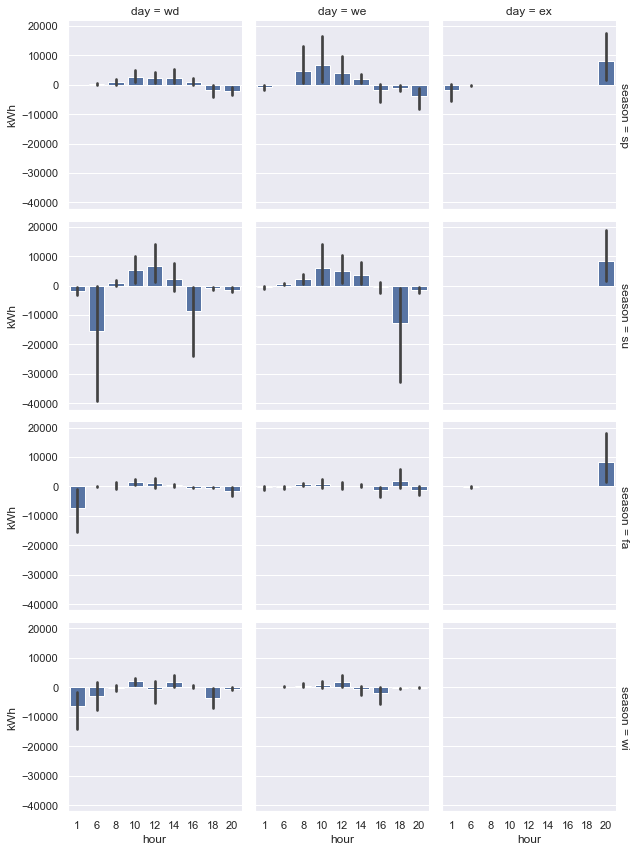

In [38]:
g = sns.FacetGrid(elStorage, row="season", col="day", margin_titles=True)
g.map(sns.barplot, "hour", "Val")
g.set_axis_labels("hour","kWh")

Text(0.5, 1.0, 'Lost Load by hour')

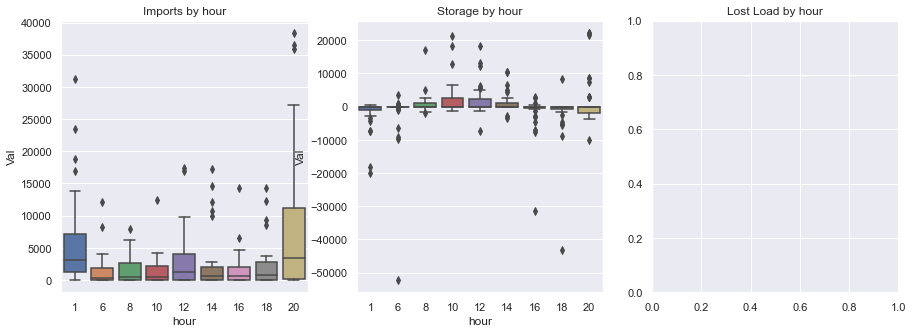

In [39]:
#Timeseries by hour
fig, ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='hour',y='Val',data=elImports, ax=ax[0])
sns.boxplot(x='hour',y='Val',data=elStorage, ax=ax[1])
#sns.boxplot(x='hour',y='Val',data=LL, ax=ax[2])

ax[0].set_title("Imports by hour")
ax[1].set_title("Storage by hour")
ax[2].set_title("Lost Load by hour")


Text(0.5, 1.0, 'Lost Load by day')

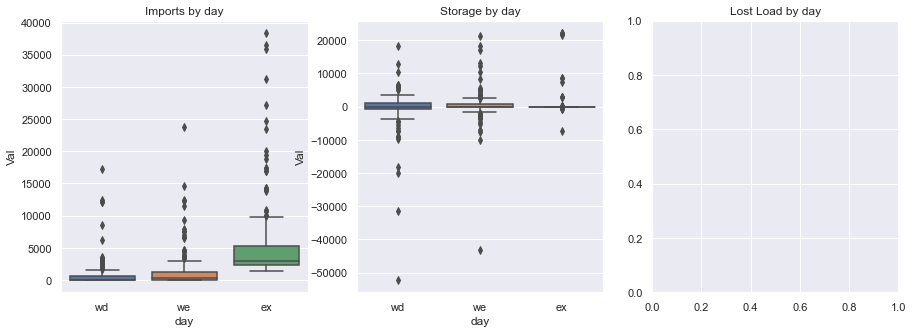

In [40]:
#Timeseries by day
fig, ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='day',y='Val',data=elImports, ax=ax[0])
sns.boxplot(x='day',y='Val',data=elStorage, ax=ax[1])
#sns.boxplot(x='day',y='Val',data=LL, ax=ax[2])

ax[0].set_title("Imports by day")
ax[1].set_title("Storage by day")
ax[2].set_title("Lost Load by day")


Text(0.5, 1.0, 'Lost Load by season')

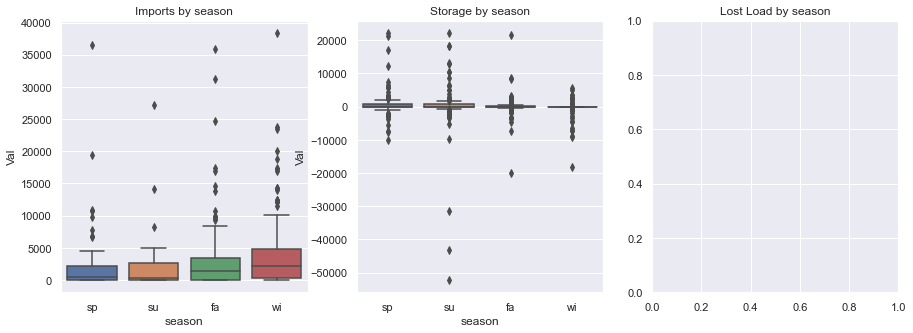

In [41]:
#Timeseries by season
fig, ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='season',y='Val',data=elImports, ax=ax[0])
sns.boxplot(x='season',y='Val',data=elStorage, ax=ax[1])
#sns.boxplot(x='season',y='Val',data=LL, ax=ax[2])

ax[0].set_title("Imports by season")
ax[1].set_title("Storage by season")
ax[2].set_title("Lost Load by season")


Text(0.5, 1.0, 'Lost Load by year')

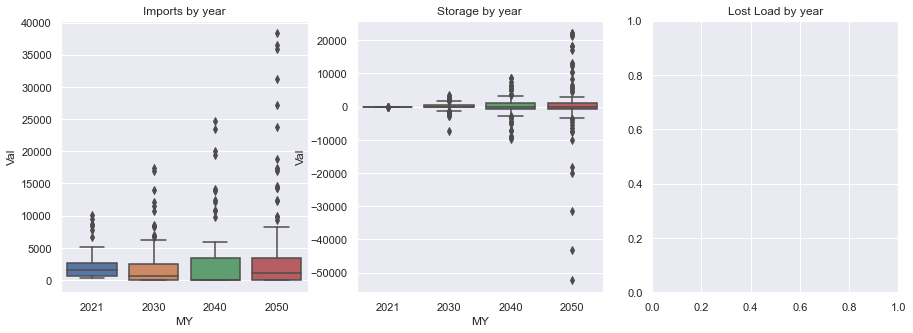

In [42]:
#Timeseries by year
fig, ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='MY',y='Val',data=elImports, ax=ax[0])
sns.boxplot(x='MY',y='Val',data=elStorage, ax=ax[1])
#sns.boxplot(x='MY',y='Val',data=LL, ax=ax[2])

ax[0].set_title("Imports by year")
ax[1].set_title("Storage by year")
ax[2].set_title("Lost Load by year")


Text(0.5, 1.0, 'Imports by year')

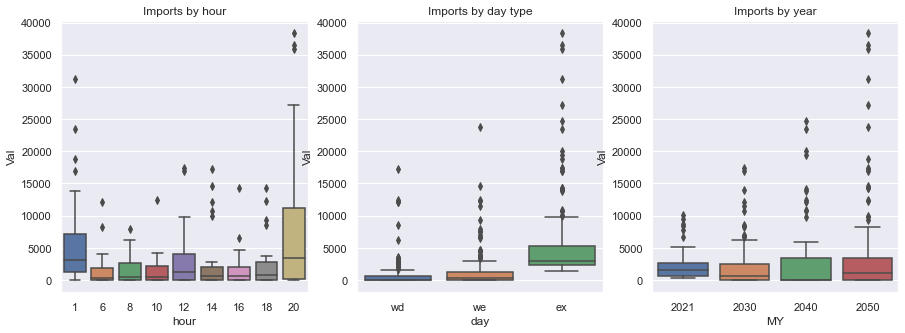

In [43]:
#Timing of imports
fig, ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='hour',y='Val',data=elImports, ax=ax[0])
sns.boxplot(x='day',y='Val',data=elImports, ax=ax[1])
sns.boxplot(x='MY',y='Val',data=elImports, ax=ax[2])

ax[0].set_title("Imports by hour")
ax[1].set_title("Imports by day type")
ax[2].set_title("Imports by year")

#elImports.groupby(by='season').Val.describe()

Text(0.5, 1.0, 'Storage by year')

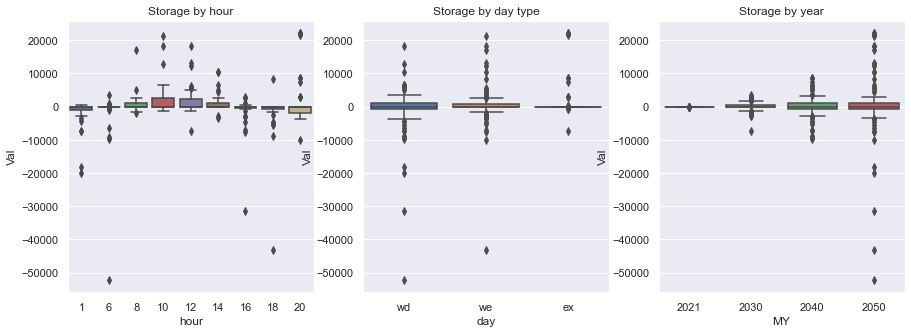

In [44]:
#Timing of storage
fig, ax=plt.subplots(1,3,figsize=(15,5))
sns.boxplot(x='hour',y='Val',data=elStorage, ax=ax[0])
sns.boxplot(x='day',y='Val',data=elStorage, ax=ax[1])
sns.boxplot(x='MY',y='Val',data=elStorage, ax=ax[2])

ax[0].set_title("Storage by hour")
ax[1].set_title("Storage by day type")
ax[2].set_title("Storage by year")

#elStorage.groupby(by='season').Val.describe()

# Imports of gas?

NameError: name 'Imports' is not defined

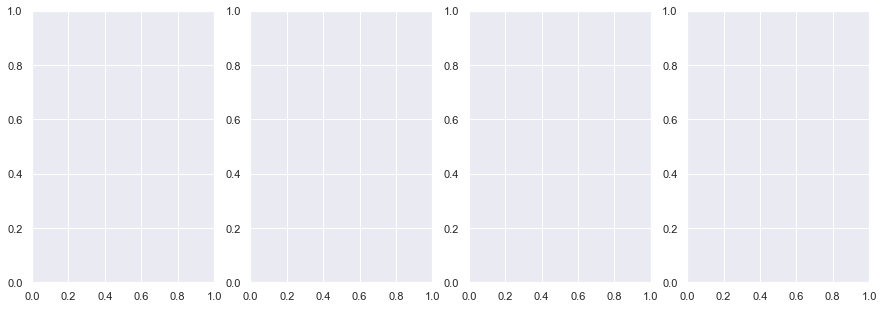

In [45]:
fig, ax=plt.subplots(1,4,figsize=(15,5))
sns.boxplot(x='hour',y='Val',data=Imports,ax=ax[0])
sns.boxplot(x='day',y='Val',data=Imports,ax=ax[1])
sns.boxplot(x='season',y='Val',data=Imports,ax=ax[2])
sns.boxplot(x='MY',y='Val',data=Imports,ax=ax[3])



In [ ]:
import ElAut, ElAutVoll
import pandas as pd

In [ ]:
eav_imports = ElAutVoll.ImportFlows
eav_imports['tot'] = eav_imports['MY'].astype(str) + "_" + eav_imports['TS'] #combine for y-axis ticks - careful since overwriting!
eavImports = pd.merge(elSurplus[['TS','MY','season','day','hour']],eav_imports[eav_imports['EC']=="gs"][['tot','Val']],left_on="TS",right_on="tot",how='left').fillna(0)

In [ ]:
ea_imports = ElAut.ImportFlows
ea_imports['tot'] = ea_imports['MY'].astype(str) + "_" + ea_imports['TS'] #combine for y-axis ticks - careful since overwriting!
eaImports = pd.merge(elSurplus[['TS','MY','season','day','hour']],ea_imports[ea_imports['EC']=="gs"][['tot','Val']],left_on="TS",right_on="tot",how='left').fillna(0)

In [ ]:
Imports = eavImports
Imports['Val'] = eavImports['Val']-eaImports['Val']

In [ ]:
fig, ax=plt.subplots(figsize=(15,5))
ax.plot(eavImports['Val'],label='Voll')
ax.plot(eaImports['Val'],label='EA')
ax.legend()

In [ ]:
Imports.groupby(by='MY')['Val'].describe()

In [ ]:
ea_yp = ElAut.YearlyProductionTS

In [ ]:
ElAutVoll.StorageTS

In [ ]:
eav_yp = ElAutVoll.YearlyProductionTS


In [ ]:
ea_yp[ea_yp['EC']=='el'].describe()

In [ ]:
eav_yp[eav_yp['EC']=='el'].describe()

In [ ]:
eav_yp['EC'].unique()